In [ ]:
#Adjustment Linkages trainer
#Multi label classification - works out which fields an adjustment affects


In [16]:
#Read the Adjustment mask into a dataframe
import pandas as pd
df=pd.read_csv('AdjustmentMask.csv')
df

,AdjustmentName,CustomerID,CustomerType,AccountType,Approach,RiskCategory,SubDivision,IsDefaulted,CountryCode,Drawn,Undrawn,PD
0,BREXIT,0,0,0,0,1,0,0,0,0,0,0
1,Noise_22d,0,0,1,0,0,0,0,0,0,0,0
2,Noise_128x,0,0,0,0,0,0,0,1,0,0,0
3,STD downgrade credit card,0,1,0,0,1,0,0,0,0,0,0
4,Noise_6f,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
19995,Noise_19b,0,0,1,0,0,0,0,0,0,0,0
19996,Market Downturn,0,0,0,0,0,0,0,0,0,0,1
19997,Market Downturn,0,0,0,0,0,0,0,0,0,0,1
19998,US Corporate Crunch,0,0,0,0,0,0,0,0,0,0,1


In [17]:
#Onehot encode the AdjustmentName
#Get first column as dataframe
X=df.iloc[:,0]
y=df.iloc[:,1:-1]

#Get dummy variables for the AdjustmentName
X=pd.get_dummies(X)
y

,CustomerID,CustomerType,AccountType,Approach,RiskCategory,SubDivision,IsDefaulted,CountryCode,Drawn,Undrawn
0,0,0,0,0,1,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0
3,0,1,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
19995,0,0,1,0,0,0,0,0,0,0
19996,0,0,0,0,0,0,0,0,0,0
19997,0,0,0,0,0,0,0,0,0,0
19998,0,0,0,0,0,0,0,0,0,0


In [18]:
#Split the test and training data
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)


In [28]:
#Build model parameterized so we can do a grid-search on hyperparameters
from keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf

def CreateModel(neurons=50, dropout=0.2,layers=3):

    #------------------PARAMETERS------------------
    num_classes=len(y.columns)
    #totalepochs=80

    #Simple feed-forward model. No U-nets or anything fancy
    ann = tf.keras.models.Sequential()

    #Variable number of layers
    for i in range(layers):
        ann.add(tf.keras.layers.Dense(units=neurons, activation='relu'))
        ann.add(tf.keras.layers.Dropout(dropout))
    
    ann.add(tf.keras.layers.Dense(units=num_classes, activation='sigmoid'))

    # ann.add(tf.keras.layers.Flatten())
    # ann.add(tf.keras.layers.Dense(num_classes, activation='softmax'))


    #Compile!
    ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    ann.build(input_shape=(None, X_train.shape[1]))
    #ann.summary()
    return ann

model = KerasClassifier(build_fn=CreateModel, verbose=0)

param_grid = {
    'epochs': [1,2,4,8,16],
    'neurons': [50, 100, 200],
    "dropout":[0.05,0.1,0.2,0.4],
    "layers":[1,2,4]
}

C:\Users\simon\AppData\Local\Temp\ipykernel_79928\2428177920.py:31: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=CreateModel, verbose=0)


In [32]:
#Basic train model
model=CreateModel(neurons=100, dropout=0.4,layers=4)
model.fit(X_train, y_train, batch_size = 32, epochs = 4)

# from sklearn.model_selection import GridSearchCV
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
# grid_result = grid.fit(X_train, y_train)
# print("Best score: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


Epoch 1/4
500/500 [==============================] - 1s 863us/step - loss: 0.1335 - accuracy: 0.5562
Epoch 2/4
500/500 [==============================] - 0s 862us/step - loss: 0.0822 - accuracy: 0.6010
Epoch 3/4
500/500 [==============================] - 0s 862us/step - loss: 0.0808 - accuracy: 0.5945
Epoch 4/4
500/500 [==============================] - 0s 847us/step - loss: 0.0798 - accuracy: 0.6037


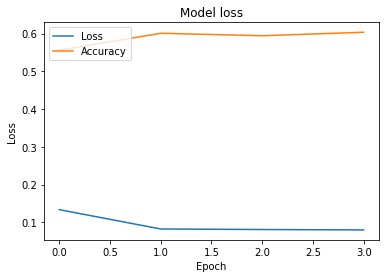

In [33]:
#Plot the loss and accuracy
import matplotlib.pyplot as plt

plt.plot(model.history.history['loss'])
plt.plot(model.history.history['accuracy'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss', 'Accuracy'], loc='upper left')
plt.show()



In [34]:
#Validate the model against the test set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

#Get the accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

125/125 [==============================] - 0s 526us/step


0.74875